In [ ]:
import random

import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mmon_gcm.alternativemodes import get_real_reaction_ids
from mmon_gcm.solving import get_weightings

# Alternative Flux Modes

Looking for alternative solutions using the method for accounting for enzyme costs outlined in Cheung et al. (2015). From the methods section:

> The commonly applied objective function of minimizing the norm (minimization of total flux with equal weighting factor) can be defined as minimize S|ci 3 vi|, where the weighting factor, ci, is identical for all reactions. To allow for the unknown costs of each flux, ci was assigned a random value between 0 and 1 from a uniform distribution for each reaction, and a flux solution was obtained by minimizing S|ci 3 vi|. Multiple flux solutions, typically 1,000 but up to 105 when a more detailed analysis was required, were computed by repeatedly solving the optimization problem, each time with a different set of randomly chosen weighting factors. An averaged flux solution was calculated by averaging the multiple flux solutions generated with different sets of ci. Note that the number of flux solutions required depends on the nature of the problem, and this can be determined by testing the robustness of the analysis.

The steps required for implementing the method are therefore:
1. Generate an matrix of n x m random weightings from a uniform distribution between 0 and 1, where n is the number of solutions required and m is the number of reactions in each phase of the model.
2. For each row of the matrix, combine these weightings with the phase-scaled weightings necessary as the phases are different lengths.
3. For each row of weightings, solve the model using pFBA
4. Take the average of all of the rows to give the averaged flux solution

This notebook includes steps 1 and 2, producing a .csv file with the matrix. [Notebook 5.2](5.2_run_alternative_flux_modes.ipynb) runs step 3 and 4, producing one .csv with all solutions and another with the averaged solution. The averaged solutions for this paper are then analysed in [Notebook 5.3](5.2_analyse_alternative_flux_modes.ipynb).

In [ ]:
model_path = "../models/4_stage_GC.json"

In [ ]:
model = cobra.io.load_json_model(model_path)

## Create matrix using just 'real' reactions

Rather than having different random weightings for the same reaction in each phase, we want the same random weighting. We also don't want to count flux for reactions that aren't 'real' like pseudoreactions, aggregator reactions, and boundary reactions. So first we generate a matrix of random numbers for just those reactions, not including the phasing:

In [ ]:
real_reaction_ids = get_real_reaction_ids(model)

In [ ]:
m = len(real_reaction_ids)
n = 1000

In [ ]:
np.random.seed(314)
random_matrix = np.random.random_sample((n, m))
random_matrix_df = pd.DataFrame(random_matrix)
random_matrix_df.columns = real_reaction_ids
random_matrix_df

,PRO_PROTON_vc_me,PRO_PROTON_vc_gc,H2O_xc_me,H2O_xc_gc,sCIT_biomass_me,sCIT_biomass_gc,ACETYLGLUTKIN_RXN_p_me,ACETYLGLUTKIN_RXN_p_gc,2KG_OAA_mc_me,2KG_OAA_mc_gc,...,aMAL_v_gc_Linker,STARCH_p_gc_Linker,STARCH_p_me_Linker,SUCROSE_total_pseudolinker,GLC_total_pseudolinker,MAL_total_pseudolinker,FRU_total_pseudolinker,K_total_pseudolinker,Cl_total_pseudolinker,CIT_total_pseudolinker
0,0.916874,0.588542,0.265048,0.783205,0.918001,0.827355,0.727951,0.260480,0.911763,0.260757,...,0.256249,0.849630,0.036859,0.352452,0.165891,0.527951,0.514265,0.573895,0.943229,0.787065
1,0.837431,0.869500,0.251766,0.851621,0.807844,0.207134,0.166586,0.491988,0.613055,0.610856,...,0.190224,0.484610,0.660262,0.944763,0.689011,0.029902,0.458717,0.648120,0.896864,0.160396
2,0.671711,0.174232,0.278023,0.959027,0.929187,0.894054,0.655200,0.942286,0.975562,0.765088,...,0.160538,0.400109,0.135024,0.272108,0.661908,0.203095,0.493434,0.395530,0.027857,0.724801
3,0.912066,0.867228,0.696670,0.350903,0.308767,0.833534,0.860486,0.601825,0.634225,0.363727,...,0.714588,0.549787,0.644255,0.187938,0.006522,0.175178,0.367586,0.702406,0.469907,0.028718
4,0.407295,0.005681,0.669659,0.742074,0.134489,0.336690,0.847053,0.454356,0.253618,0.395133,...,0.279085,0.015945,0.397974,0.670957,0.761961,0.857324,0.689408,0.500088,0.837236,0.786871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.549238,0.983931,0.616316,0.979573,0.991521,0.623560,0.240054,0.150167,0.076900,0.904664,...,0.624767,0.508215,0.721488,0.125900,0.341007,0.194615,0.169541,0.113740,0.643763,0.949376
996,0.298990,0.557697,0.919112,0.632737,0.205327,0.793606,0.883850,0.878186,0.757498,0.657648,...,0.730948,0.511767,0.178073,0.767833,0.274780,0.684812,0.523172,0.947464,0.204050,0.006956
997,0.310442,0.141863,0.507655,0.597543,0.309384,0.705092,0.469655,0.942340,0.362111,0.298743,...,0.494237,0.832757,0.152577,0.365978,0.656360,0.722871,0.537215,0.830815,0.864335,0.227395
998,0.087585,0.461775,0.996273,0.740516,0.224738,0.552139,0.189635,0.652741,0.267166,0.568535,...,0.035277,0.494617,0.816259,0.991288,0.463856,0.375362,0.745862,0.900269,0.183644,0.821859


## Expand matrix to include all reactions in model

Now we use this dataframe with random weightings and transfer it to all of the reactions in the model. The random weighting is the same across phases for each reaction and set to zero for reactions that are not 'real'.

In [ ]:
all_reactions_random_weightings_dict = {}
for reaction in model.reactions:
    if reaction.id[:-2] in random_matrix_df.columns:
        all_reactions_random_weightings_dict[reaction.id] = random_matrix_df.loc[:, reaction.id[:-2]]
    else:
        all_reactions_random_weightings_dict[reaction.id] = np.zeros(len(random_matrix_df.index))
random_weights_df = pd.DataFrame.from_dict(all_reactions_random_weightings_dict)
random_weights_df

,EX_X_pi_t_me_1,EX_X_pi_t_me_2,EX_X_pi_t_me_3,EX_X_pi_t_me_4,EX_X_pi_t_gc_1,EX_X_pi_t_gc_2,EX_X_pi_t_gc_3,EX_X_pi_t_gc_4,EX_X_CO2_t_me_1,EX_X_CO2_t_me_2,...,K_total_pseudolinker_3,K_total_pseudolinker_4,Cl_total_pseudolinker_1,Cl_total_pseudolinker_2,Cl_total_pseudolinker_3,Cl_total_pseudolinker_4,CIT_total_pseudolinker_1,CIT_total_pseudolinker_2,CIT_total_pseudolinker_3,CIT_total_pseudolinker_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.573895,0.573895,0.943229,0.943229,0.943229,0.943229,0.787065,0.787065,0.787065,0.787065
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.648120,0.648120,0.896864,0.896864,0.896864,0.896864,0.160396,0.160396,0.160396,0.160396
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.395530,0.395530,0.027857,0.027857,0.027857,0.027857,0.724801,0.724801,0.724801,0.724801
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.702406,0.702406,0.469907,0.469907,0.469907,0.469907,0.028718,0.028718,0.028718,0.028718
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500088,0.500088,0.837236,0.837236,0.837236,0.837236,0.786871,0.786871,0.786871,0.786871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.113740,0.113740,0.643763,0.643763,0.643763,0.643763,0.949376,0.949376,0.949376,0.949376
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.947464,0.947464,0.204050,0.204050,0.204050,0.204050,0.006956,0.006956,0.006956,0.006956
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.830815,0.830815,0.864335,0.864335,0.864335,0.864335,0.227395,0.227395,0.227395,0.227395
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.900269,0.900269,0.183644,0.183644,0.183644,0.183644,0.821859,0.821859,0.821859,0.821859


## Combine random weights with phase-weighting

As we've done previously, we want to adjust the weights of reactions to take into account the different lengths of phases. 

In [ ]:
full_weights_df = pd.Series(get_weightings(model)) * random_weights_df
full_weights_df = full_weights_df.round(8)  # round to bring down below git max file size
full_weights_df

,10_FORMYL_THF_pc_gc_1,10_FORMYL_THF_pc_gc_2,10_FORMYL_THF_pc_gc_3,10_FORMYL_THF_pc_gc_4,10_FORMYL_THF_pc_me_1,10_FORMYL_THF_pc_me_2,10_FORMYL_THF_pc_me_3,10_FORMYL_THF_pc_me_4,1TRANSKETO_RXN_p_gc_1,1TRANSKETO_RXN_p_gc_2,...,sSUC_biomass_me_3,sSUC_biomass_me_4,unlProtHYPO_c_gc_1,unlProtHYPO_c_gc_2,unlProtHYPO_c_gc_3,unlProtHYPO_c_gc_4,unlProtHYPO_c_me_1,unlProtHYPO_c_me_2,unlProtHYPO_c_me_3,unlProtHYPO_c_me_4
0,3.196322,0.266360,6.126284,3.196322,2.003810,0.166984,3.840636,2.003810,4.628290,0.385691,...,3.685919,1.923088,3.013075,0.251090,5.775060,3.013075,4.919640,0.409970,9.429310,4.919640
1,2.976393,0.248033,5.704753,2.976393,0.059372,0.004948,0.113797,0.059372,3.306903,0.275575,...,11.088275,5.785187,4.092069,0.341006,7.843133,4.092069,0.268098,0.022342,0.513855,0.268098
2,3.812475,0.317706,7.307244,3.812475,3.160252,0.263354,6.057151,3.160252,1.036738,0.086395,...,5.557520,2.899576,3.424889,0.285407,6.564371,3.424889,1.629429,0.135786,3.123073,1.629429
3,0.186226,0.015519,0.356934,0.186226,1.913905,0.159492,3.668317,1.913905,4.470282,0.372524,...,2.648911,1.382040,4.475259,0.372938,8.577580,4.475259,0.418057,0.034838,0.801276,0.418057
4,1.899401,0.158283,3.640519,1.899401,1.419532,0.118294,2.720771,1.419532,3.441213,0.286768,...,4.127187,2.153315,3.283695,0.273641,6.293748,3.283695,4.740312,0.395026,9.085597,4.740312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.852690,0.237724,5.467655,2.852690,0.020950,0.001746,0.040154,0.020950,3.208964,0.267414,...,5.407379,2.821241,5.569828,0.464152,10.675504,5.569828,1.066897,0.088908,2.044886,1.066897
996,2.628661,0.219055,5.038267,2.628661,3.061566,0.255130,5.868001,3.061566,0.898539,0.074878,...,8.525851,4.448270,5.790531,0.482544,11.098518,5.790531,3.936361,0.328030,7.544692,3.936361
997,1.765245,0.147104,3.383386,1.765245,1.824386,0.152032,3.496741,1.824386,1.165449,0.097121,...,10.186639,5.314768,0.586656,0.048888,1.124424,0.586656,4.460932,0.371744,8.550119,4.460932
998,2.427627,0.202302,4.652951,2.427627,1.101725,0.091810,2.111640,1.101725,1.543910,0.128659,...,9.506838,4.960089,3.335862,0.277988,6.393735,3.335862,0.364925,0.030410,0.699439,0.364925


## Confirm uniform distributions:

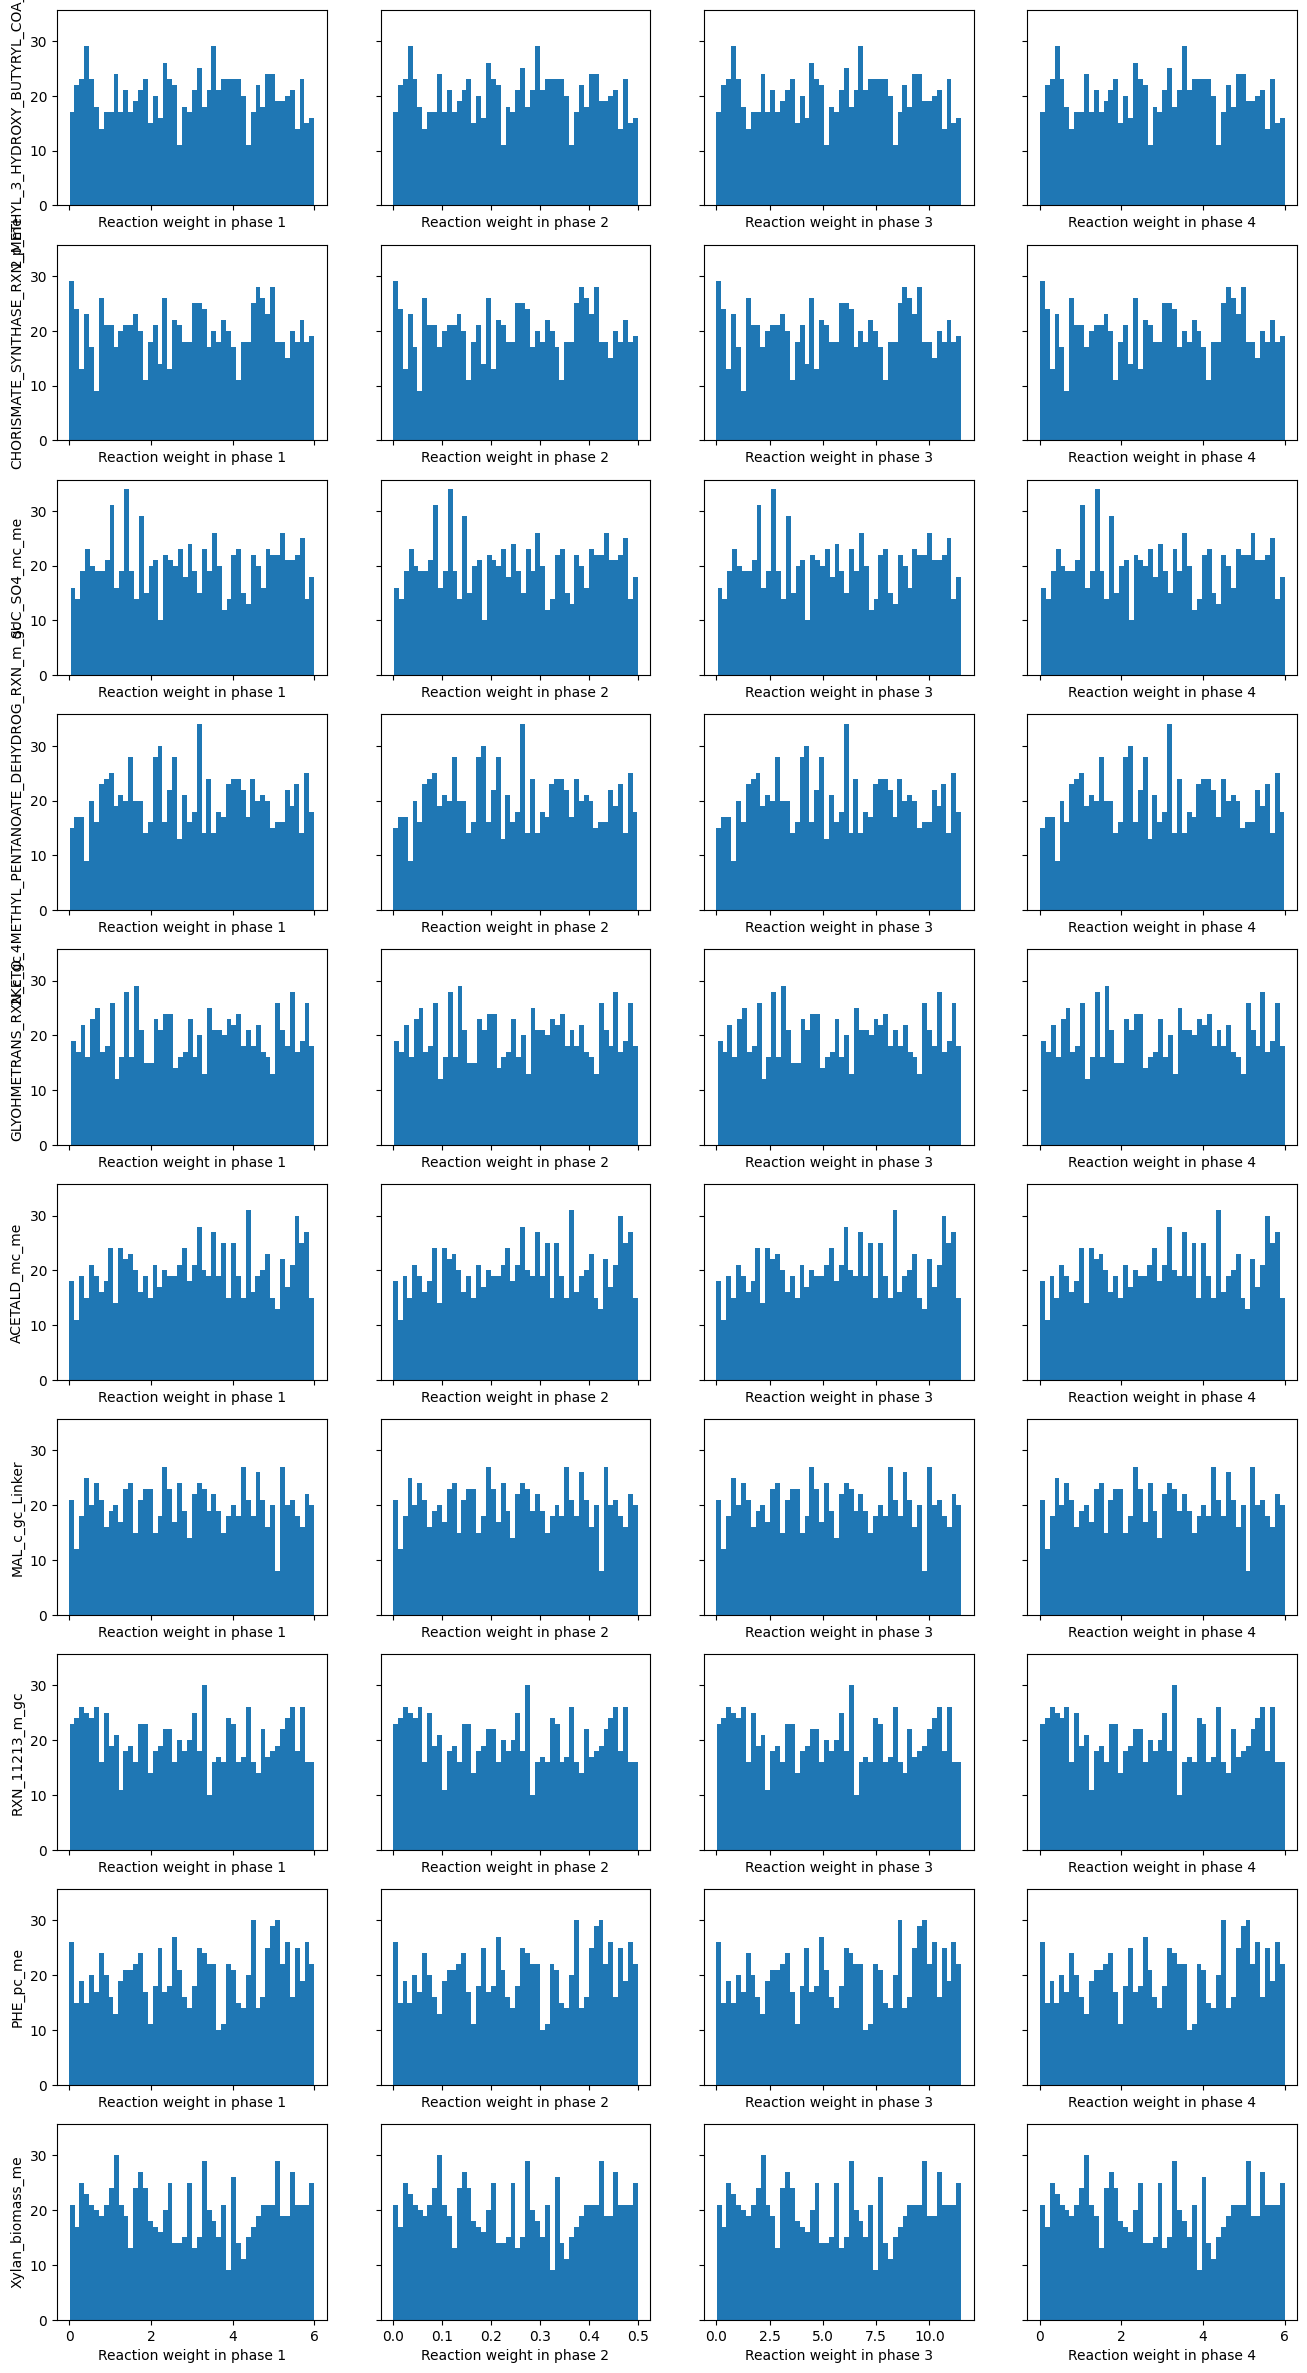

In [ ]:
random_ids = random.sample(real_reaction_ids, 10)

fig, axs = plt.subplots(len(random_ids), 4, figsize=(4 * 4, 3 * len(random_ids)), sharex="col", sharey=True)

for x in range(4):
    for y in range(len(random_ids)):
        axs[y][x].hist(full_weights_df.loc[:, f"{random_ids[y]}_{x + 1}"], bins=50)
        axs[y][x].set_xlabel(f"Reaction weight in phase {x + 1}")
        axs[y][0].set_ylabel(random_ids[y])

In [ ]:
full_weights_df.to_csv("../outputs/alternative_weighting/alternative_weights.csv")